In [5]:
isMac = False # Set this to False if running on cpu and using torch

In [24]:
# for plotting, run: pip install pandas matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.signal import medfilt, sosfilt, ellip, iirnotch, freqz, filtfilt
from sklearn.preprocessing import MinMaxScaler

import wfdb
!pip install -q gluonts

from gluonts.dataset.pandas import PandasDataset

In [25]:
if isMac:
    from chronos_mlx import ChronosPipeline
    pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    dtype="bfloat16",
    )
else:
    import torch
    from chronos import ChronosPipeline
    pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
    )

/home/tammer/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [30]:
data_dir = '../data/samples'

np.random.seed(0)
random_file_choice = ['/'+x for x in np.random.choice(os.listdir(data_dir), min(len(os.listdir(data_dir)), 10), replace=False)]
random_file_choice

['/100.atr', '/100.hea', '/100.dat', '/100.xws']

In [31]:
filename_list = list(set([x[:-4] for x in random_file_choice if x[:-4] + '.dat' in random_file_choice]))
filename_list

['/100']

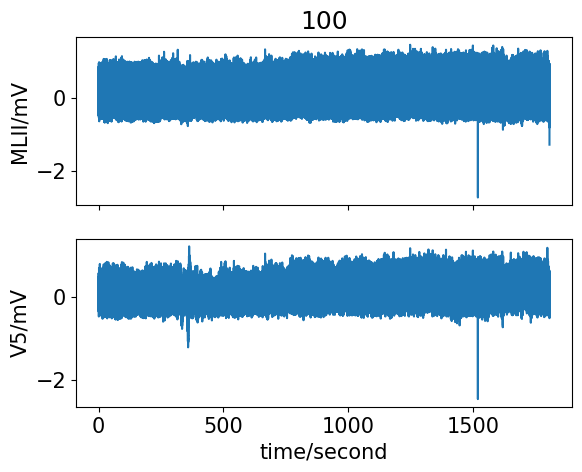

In [32]:
for filename_base in filename_list:
    file_path = data_dir + filename_base

    record = wfdb.rdrecord(file_path)

    # plot the record to screen
    wfdb.plot_wfdb(record=record, title=f'{filename_base[1:]}')

,MLII
0 days 00:00:00,-0.145
0 days 00:00:00.002777777,-0.145
0 days 00:00:00.005555554,-0.145
0 days 00:00:00.008333331,-0.145
0 days 00:00:00.011111108,-0.145
...,...
0 days 00:30:05.541161115,-0.075
0 days 00:30:05.543938892,-0.445
0 days 00:30:05.546716669,-0.675
0 days 00:30:05.549494446,-0.765


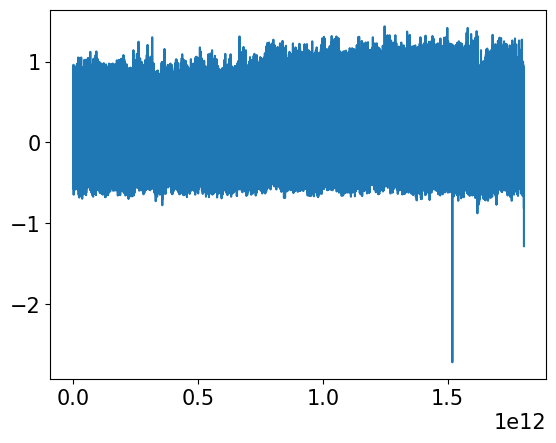

In [33]:
# Raw Data Representation

MLII = record.to_dataframe()[['MLII']]
display(MLII)
plt.plot(MLII)

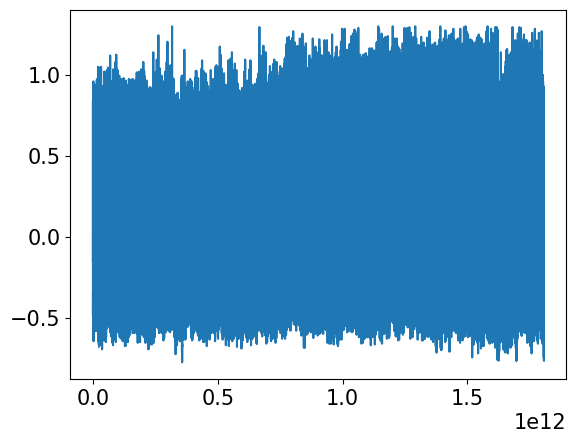

In [34]:

MLII_quantiles = np.quantile(MLII, [0.00005,0.99995])
MLII[((MLII>MLII_quantiles[0]) | (MLII<MLII_quantiles[1]))]

MLII = MLII[((MLII>MLII_quantiles[0]) & (MLII<MLII_quantiles[1]))].ffill()
plt.plot(MLII)

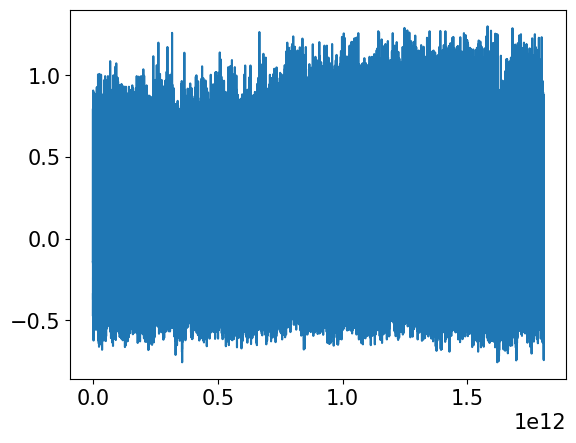

In [35]:
# With Simple Moving Average (3 frame window)

MLII_SMA = MLII.rolling(3).mean()
plt.plot(MLII_SMA)

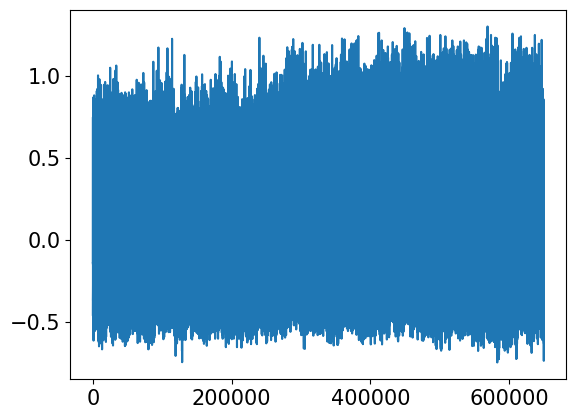

In [36]:
# With median filtering

MLII_medfilt = medfilt((MLII_SMA).values.flatten(),3)
MLII_medfilt = pd.Series(MLII_medfilt).bfill()
plt.plot(MLII_medfilt)

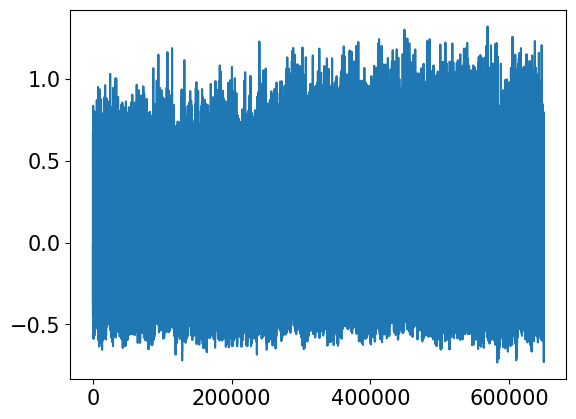

In [37]:
# With second-order section filter

sos = ellip(N = 2, rp = 0.09, rs = 80, Wn = 0.09, output='sos')
MLII_sos = sosfilt(sos, MLII_medfilt)
plt.plot(MLII_sos)

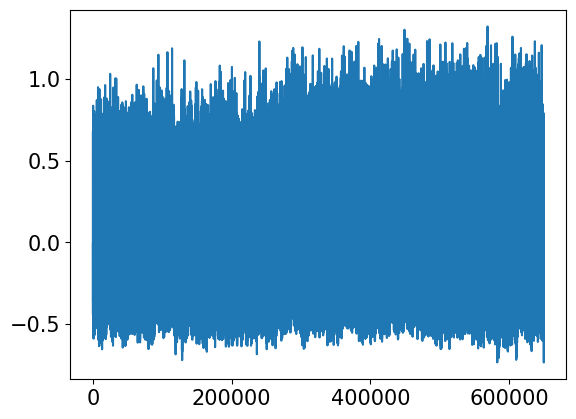

In [38]:
# Remove 60Hz analog-digital conversion tone from signal

fs = 360.0  # Sample frequency (Hz)

f0 = 60.0  # Frequency to be removed from signal (Hz)

Q = 30.0  # Quality factor

# Design notch filter

b_notch, a_notch = iirnotch(f0, Q, fs)

MLII_notch = filtfilt(b_notch, a_notch, MLII_sos)
plt.plot(MLII_notch)

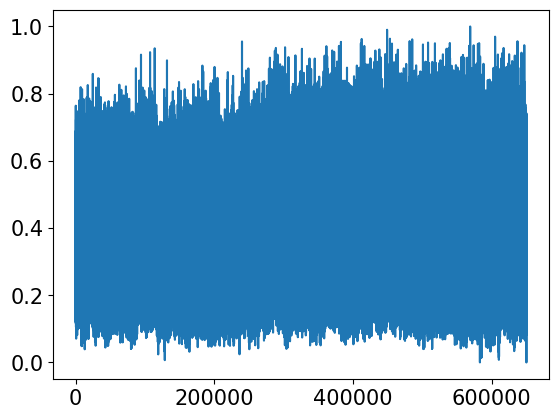

In [39]:
# Normalize for (0,1)

scaler = MinMaxScaler()

MLII_minmax = scaler.fit_transform(MLII_notch.reshape((-1,1))).flatten()
plt.plot(MLII_minmax)

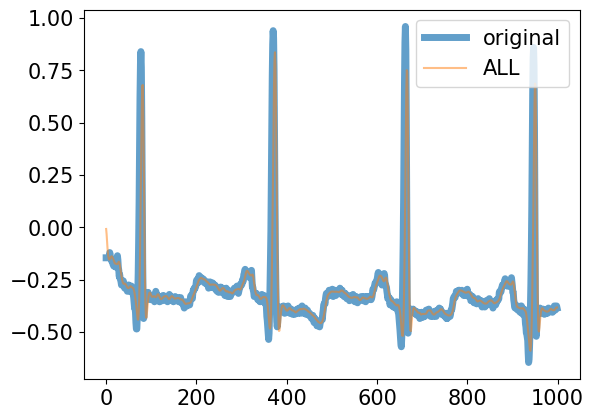

In [40]:
#Show difference from original and processed signal

plt.plot(MLII.values[:1000], label = 'original', alpha = 0.7, linewidth = 5)
plt.plot(MLII_notch[:1000], label ='ALL', alpha = 0.5)
plt.legend()
plt.show()


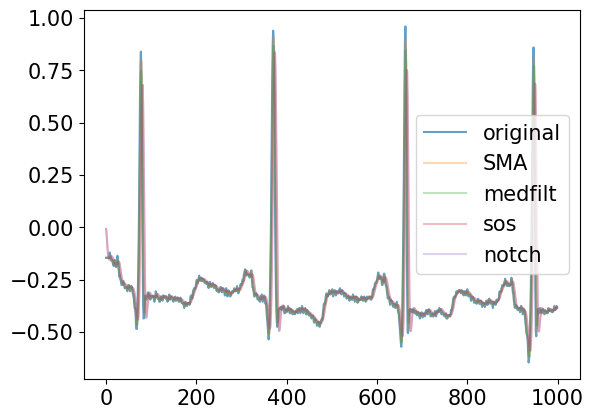

In [41]:
# All signals plotted

plt.plot(MLII.values[:1000], label = 'original', alpha = 0.7)
plt.plot(MLII_SMA.values[:1000], label = 'SMA', alpha = 0.3)
plt.plot(MLII_medfilt[:1000], label = 'medfilt', alpha = 0.3)
plt.plot(MLII_sos[:1000], label = 'sos', alpha = 0.3)
plt.plot(MLII_notch[:1000], label = 'notch', alpha = 0.3)
plt.legend()

In [21]:
####  The following Code is not likely to work without further development.  
####  Left here as a starting place for passing processed data.

AssertionError: 

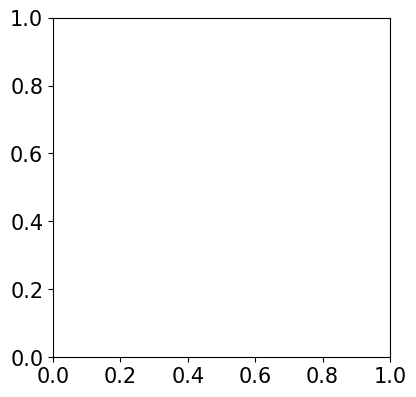

In [22]:
df_wide = pd.read_csv(data_dir + random_file_choice[0], names = ['Lead-'+ str(f) for f in range(1,13)])

plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, feature_name in enumerate(df_wide.columns):
    ax = plt.subplot(3, 4, idx+1)
    df_feat = df_wide[feature_name].reset_index()
    prediction_length = 50
    context_length = 200
    context_start_position = len(df_feat) - prediction_length - context_length
    context = df_feat[feature_name].values[context_start_position:context_start_position+context_length]
    true_ts = df_feat[feature_name].values[context_start_position:]
    forecast = pipeline.predict(
        context,
        prediction_length,
        num_samples=20,
        temperature=1.0,
        top_k=100,
        top_p=1,
    ) # forecast shape: [num_series, num_samples, prediction_length]

    # visualize the forecast
    ts_index = range(len(df_feat)-prediction_length*4, len(df_feat))
    forecast_index = range(context_start_position+context_length, len(df_feat))
    low, median, high = np.quantile(forecast[0], [0.1, 0.5, 0.9], axis=0)

    # plt.figure(figsize=(8, 4))
    ax.plot(ts_index, df_feat[feature_name].values[-prediction_length*4:], color="royalblue", label="historical data")
    ax.plot(forecast_index, median, color="tomato", label="median forecast")
    ax.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
    ax.set_title(feature_name)    

    ax.grid()

plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 2))
plt.suptitle('Chronos - ECG Leads (Denoised)', y=1.03, fontsize = 30)
plt.show()


In [23]:
df_wide = pd.read_csv(data_dir + standard_ecg_dir + random_file_choice[0], header=0, names = ['Lead-'+ str(f) for f in range(1,13)])

plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, feature_name in enumerate(df_wide.columns):
    ax = plt.subplot(3, 4, idx+1)
    df_feat = df_wide[feature_name].reset_index()
    prediction_length = 50
    context_length = 200
    context_start_position = len(df_feat) - prediction_length - context_length
    context = df_feat[feature_name].values[context_start_position:context_start_position+context_length]
    true_ts = df_feat[feature_name].values[context_start_position:]
    forecast = pipeline.predict(
        context,
        prediction_length,
        num_samples=100,
        temperature=1,
        top_k=100,
        top_p=1.0,
    ) # forecast shape: [num_series, num_samples, prediction_length]

    # visualize the forecast
    ts_index = range(len(df_feat)-prediction_length*4, len(df_feat))
    forecast_index = range(context_start_position+context_length, len(df_feat))
    low, median, high = np.quantile(forecast[0], [0.1, 0.5, 0.9], axis=0)

    # plt.figure(figsize=(8, 4))
    ax.plot(ts_index, df_feat[feature_name].values[-prediction_length*4:], color="royalblue", label="historical data")
    ax.plot(forecast_index, median, color="tomato", label="median forecast")
    ax.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
    ax.set_title(feature_name)    

    ax.grid()

plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 2))
plt.suptitle('Chronos - ECG Leads (Noisy)', y=1.03, fontsize = 30)
plt.show()

NameError: name 'standard_ecg_dir' is not defined